# Heart Rate Filtering

Knowing an athlete's heart rate maximum is essential to identify portions of their ride in which Heart Rate Recovery (30) can be calculated. Since the athlete's self-reported age as stored on the Golden Cheetah database has been found to be unreliable, we have to rely on the heart-rate data from each ride to identify each athlete's maximum. The challenge we face here is that simply selecting the maximum heart rate value for an athlete's data might not be accurate. We suspect some of these really high heart rate values to be instrument errors. Therefore, the need arises to apply a filter to the heart rate data from each ride before identifying the maximum value. 

This notebook applies the median_filter and the Hamel filter to an athlete's data that we know has extremely high heart rate values that are likely erroneous. 

In [2]:
# Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from opendata import OpenData  # Golden Cheetah python library

In [3]:
od = OpenData()

In [4]:
# Accessing data for the sample athlete (2e99)

athlete = od.get_remote_athlete("0066cbd9-2072-472f-8018-2e320f0b2e99")
activities = list(athlete.activities())

In [5]:
# Choosing an activity which we know has an extremely high heart rate (149 bpm)
activity = activities[1693].data

<Axes: title={'center': 'Original Heart Rate Data'}, xlabel='Time (seconds)', ylabel='Heart Rate (bpm)'>

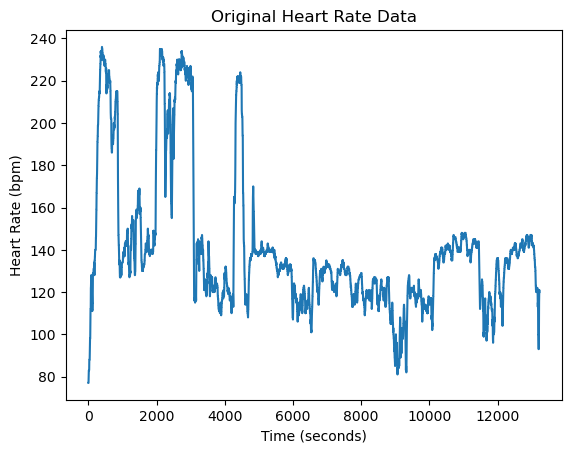

In [6]:
# Plotting the original heart rate data
activity["hr"].plot(
    title="Original Heart Rate Data", xlabel="Time (seconds)", ylabel="Heart Rate (bpm)"
)

In [7]:
# Data description of original heart rate data

activity["hr"].describe()

count    13225.000000
mean       140.769414
std         33.997304
min         77.000000
25%        119.000000
50%        133.000000
75%        143.000000
max        236.000000
Name: hr, dtype: float64

## Median Filter

In this section, I will apply the *scipy.ndimage.median_filter* to the heart rate data and compare the filtered data to the original.

In [8]:
# Importing packages

from scipy.ndimage import median_filter

In [9]:
# Converting the heart rate data to a numpy array

hr_array = activity["hr"].to_numpy()

In [10]:
# Applying the median filter to the heart rate array

hr_array_filtered = median_filter(hr_array, size=61)

In [11]:
# Adding filtered heart rate data to the activity dataframe

activity["hr_med_filter"] = pd.Series(hr_array_filtered)

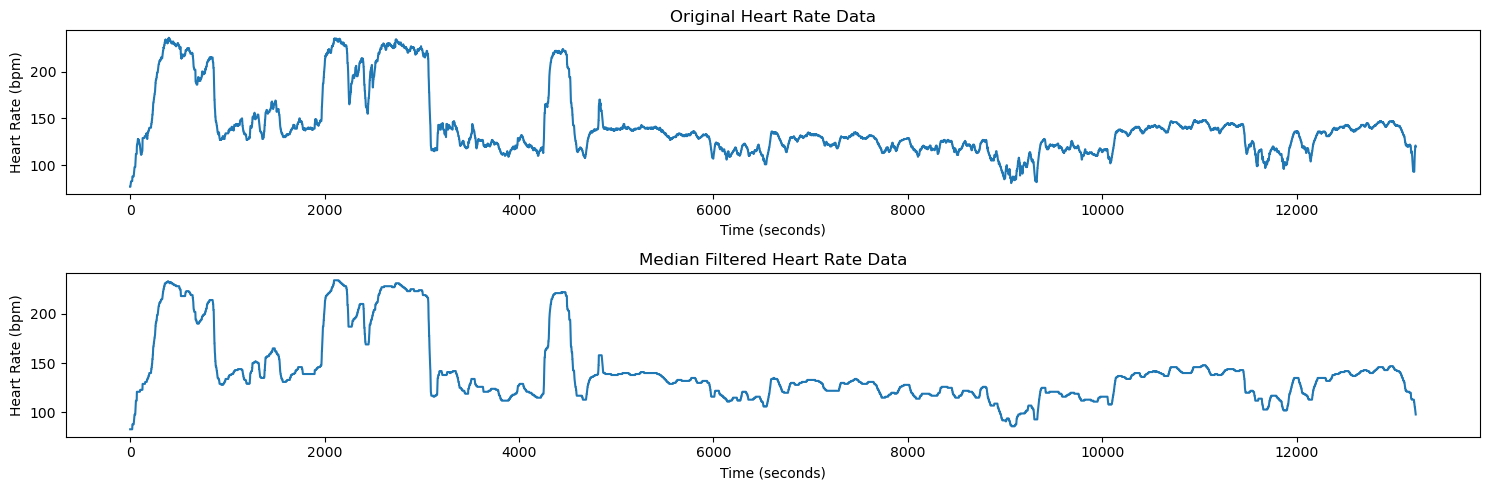

In [21]:
# Plotting original and filtered heart rate data for comparison.

fig, ax = plt.subplots(2, 1, figsize=(15, 5))

activity["hr"].plot(
    title="Original Heart Rate Data",
    xlabel="Time (seconds)",
    ylabel="Heart Rate (bpm)",
    ax=ax[0],
)

activity["hr_med_filter"].plot(
    title="Median Filtered Heart Rate Data",
    xlabel="Time (seconds)",
    ylabel="Heart Rate (bpm)",
    ax=ax[1],
)

plt.tight_layout()
plt.show()


In [13]:
# Data description of filtered heart rate data

activity["hr_med_filter"].describe()

count    13225.000000
mean       140.898563
std         33.841756
min         83.000000
25%        120.000000
50%        133.000000
75%        142.000000
max        234.000000
Name: hr_med_filter, dtype: float64

In [14]:
activity.head()

,secs,km,power,hr,cad,alt,hr_med_filter
0,0,0.0000,0.0,77.0,33.0,526.4,83.0
1,1,0.0032,67.0,77.0,34.0,526.4,83.0
2,2,0.0068,79.0,77.0,34.0,526.0,83.0
3,3,0.0110,85.0,78.0,42.0,525.8,83.0
4,4,0.0152,40.0,79.0,52.0,525.6,83.0


## Hampel Filter

In this section, I will apply the *HampelFilter* from SkTime to the heart rate data and compare the filtered data to the original.

In [36]:
# Importing packages

from sktime.transformations.series.outlier_detection import HampelFilter

In [37]:
# Converting the heart rate data to a numpy array

hr_array = activity["hr"].to_numpy()

In [38]:
# Applying the Hampel filter to the heart rate array

hr_array_filtered = HampelFilter().fit_transform(pd.Series(hr_array))

In [40]:
# Adding filtered heart rate data to the activity dataframe

activity["hr_hampel_filter"] = pd.Series(hr_array_filtered)

In [43]:
# Imputing nan values in the "hr_hampel_filter" column using the backfill method

activity["hr_hampel_filter"].bfill(inplace=True)

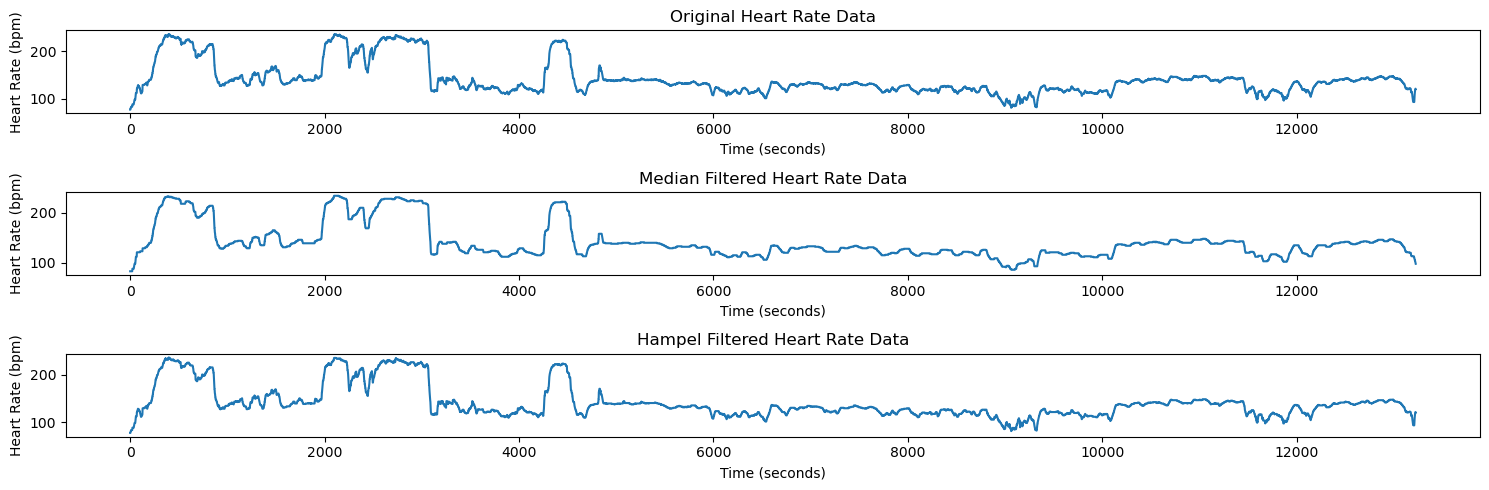

In [ ]:
# Plotting original, median filtered and Hampel filtered heart rate data for comparison.

fig, ax = plt.subplots(3, 1, figsize=(15, 5))

activity["hr"].plot(
    title="Original Heart Rate Data",
    xlabel="Time (seconds)",
    ylabel="Heart Rate (bpm)",
    ax=ax[0],
)

activity["hr_med_filter"].plot(
    title="Median Filtered Heart Rate Data",
    xlabel="Time (seconds)",
    ylabel="Heart Rate (bpm)",
    ax=ax[1],
)

activity["hr_hampel_filter"].plot(
    title="Hampel Filtered Heart Rate Data",
    xlabel="Time (seconds)",
    ylabel="Heart Rate (bpm)",
    ax=ax[2],
)

plt.tight_layout()
plt.show()

In [48]:
# Saving the filtered heart rate data to a csv file

activity.to_csv(r"..\data\external\2e99_activity.csv", index=False)